<a href="https://colab.research.google.com/github/AthmikaU/dl/blob/main/DL_prg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DL 1

Solve XOR problem using multilayer perceptron.

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam

# Step 1 : Prepare the XOR data (4 samples with 2 inputs)
x = np.array([[0,0],[0,1],[1,0],[1,1]])
y = np.array([[0],[1],[1],[0]])  # Correct shape (4,1)

# 2 : Define MLP Model
model = Sequential()
model.add(Input(shape=(2,)))
model.add(Dense(2, activation='relu'))
# model.add(Dense(2, activation='tanh'))
model.add(Dense(1, activation='sigmoid'))

# 3 : Compile the model
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.01), metrics=['accuracy'])

# 4 : Train the model
model.fit(x, y, epochs=5000, verbose=0)
# verbose=0 HIDES training logs

# Evaluate
loss, accuracy = model.evaluate(x, y, verbose=0)
print(f'Accuracy: {accuracy*100:.2f}%')

# make predictions
predictions = model.predict(x)
predictions = (predictions > 0.5).astype(float)

print("\nPredictions:")
for i, prediction in enumerate(predictions):
    print(f"Input: {x[i]}, Predicted Output: {prediction[0]} - True Output: {y[i][0]}")


Accuracy: 75.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step

Predictions:
Input: [0 0], Predicted Output: 1.0 - True Output: 0
Input: [0 1], Predicted Output: 1.0 - True Output: 1
Input: [1 0], Predicted Output: 1.0 - True Output: 1
Input: [1 1], Predicted Output: 0.0 - True Output: 0


In [17]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np

# XOR Data
X_data = np.array([[0,0],[0,1],[1,0],[1,1]])
Y_data = np.array([[0],[1],[1],[0]])

# Placeholders
X = tf.placeholder(tf.float32, [4, 2])
Y = tf.placeholder(tf.float32, [4, 1])

# Hyperparameters
learning_rate = 0.01
epochs = 20000

# Hidden Layer with 4 neurons
with tf.variable_scope('hidden'):
    h_w = tf.Variable(tf.random_normal([2, 4]))
    h_b = tf.Variable(tf.zeros([4]))
    h = tf.nn.tanh(tf.matmul(X, h_w) + h_b)

# Output Layer
with tf.variable_scope('output'):
    o_w = tf.Variable(tf.random_normal([4, 1]))
    o_b = tf.Variable(tf.zeros([1]))
    Y_logits = tf.matmul(h, o_w) + o_b
    Y_pred = tf.nn.sigmoid(Y_logits)

# Loss & Optimizer
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Y_logits, labels=Y))
train = tf.train.AdamOptimizer(learning_rate).minimize(loss)

# Train session
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    for epoch in range(epochs):
        sess.run(train, feed_dict={X: X_data, Y: Y_data})

    # Predictions
    Y_out = sess.run(Y_pred, feed_dict={X: X_data})
    Y_out_rounded = (Y_out > 0.5).astype(float)

    # Accuracy
    accuracy = np.mean(Y_out_rounded == Y_data)
    print(f"\nAccuracy: {accuracy*100:.2f}%\n")

    # Predictions printout
    print("Predictions:")
    for i in range(len(X_data)):
        print(f"Input: {X_data[i]}, Predicted Output: {Y_out_rounded[i][0]} - True Output: {Y_data[i][0]}")


Accuracy: 100.00%

Predictions:
Input: [0 0], Predicted Output: 0.0 - True Output: 0
Input: [0 1], Predicted Output: 1.0 - True Output: 1
Input: [1 0], Predicted Output: 1.0 - True Output: 1
Input: [1 1], Predicted Output: 0.0 - True Output: 0


# DL 2

Implement regularization techniques in deep learning models using parameter norm penalties, dataset augmentation, and noise robustness for improved generalization.

In [ ]:
import tensorflow as tf  # deep learning framework
from tensorflow import keras
from tensorflow.keras import layers, regularizers
import numpy as np  # numerical operations

# Load MNIST images and labels
(x_train, y_train), _ = keras.datasets.mnist.load_data()

# Normalize pixel values to 0–1 range
x_train = x_train.astype('float32')/255

# Add channel dimension (28,28) → (28,28,1)
x_train = np.expand_dims(x_train, -1)

# Convert labels to one-hot encoding (0–9)
y_train = tf.keras.utils.to_categorical(y_train, 10)

# Add small random noise for robustness
noise = 0.05 * np.random.normal(size=x_train.shape)
x_train = np.clip(x_train+noise, 0., 1.)  # keep values between 0 and 1

# Data augmentation (small rotations and shifts)
datagen = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=10,         # rotate images
    width_shift_range=0.1,     # shift left/right
    height_shift_range=0.1,    # shift up/down
    validation_split=0.2       # 20% for validation
)

datagen.fit(x_train)  # compute stats for augmentation

# Build a simple fully-connected neural network
model = keras.Sequential([
    layers.Flatten(input_shape=(28, 28, 1)),  # flatten 2D image into vector
    layers.Dense(256, activation='relu',
                 kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)),  # L1+L2 regularization
    layers.Dropout(0.5),  # drop 50% neurons to prevent overfitting
    layers.Dense(128, activation='relu',
                 kernel_regularizer=regularizers.l2(1e-4)),  # extra L2 penalty
    layers.Dropout(0.3),  # drop 30% neurons
    layers.Dense(10, activation='softmax')  # final output for 10 classes
])

# Compile model with optimizer, loss and accuracy
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Stop training early if validation loss stops improving
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=3,
    restore_best_weights=True
)

# Train the model with augmented images
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=128, subset='training'),
    validation_data=datagen.flow(x_train, y_train, batch_size=128, subset='validation'),
    epochs=50,
    callbacks=[early_stop]  # stop early if needed
)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 23s 58ms/step - accuracy: 0.5208 - loss: 1.5361 - val_accuracy: 0.8840 - val_loss: 0.5173
Epoch 2/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 22s 58ms/step - accuracy: 0.8242 - loss: 0.6824 - val_accuracy: 0.9212 - val_loss: 0.3879
Epoch 3/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 22s 60ms/step - accuracy: 0.8636 - loss: 0.5653 - val_accuracy: 0.9355 - val_loss: 0.3470
Epoch 4/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 21s 55ms/step - accuracy: 0.8821 - loss: 0.5108 - val_accuracy: 0.9434 - val_loss: 0.3173
Epoch 5/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 21s 57ms/step - accuracy: 0.8899 - loss: 0.4763 - val_accuracy: 0.9488 - val_loss: 0.3015
Epoch 6/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 28s 74ms/step - accuracy: 0.8993 - loss: 0.4556 - val_accuracy: 0.9525 - val_loss: 0.2867
Epoch 7/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 22s 57ms/step - accuracy: 0.9028 - loss: 0.4415 - val_accuracy: 0.9526 - val_loss: 0.2903
Epoch 8/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 21s 57ms/step - accuracy: 0.9071 - loss: 0.4251 - 

# DL 3

Implement and compare different optimization algorithms [SGD, Momentum, Adam] for training a simple neural network on a toy dataset.

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


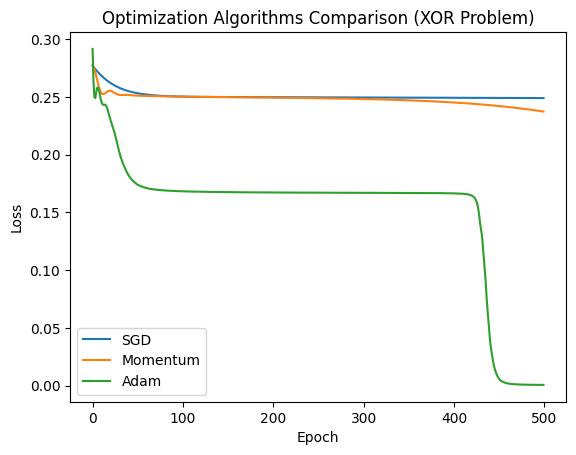

Final loss (SGD): 0.24897170066833496
Final loss (Momentum): 0.23731040954589844
Final loss (Adam): 0.000568293733522296


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers, losses
import numpy as np
import matplotlib.pyplot as plt

X = np.array([[0,0], [0,1], [1,0], [1,1]], dtype=np.float32)
y = np.array([[0],[1],[1],[0]], dtype=np.float32)

def create_model():
  model = keras.Sequential([
      layers.Dense(4, input_dim=2, activation='sigmoid'),
      layers.Dense(1, activation='sigmoid')
  ])
  return model

def train_model(optimizer_name, X, y, epochs=500, lr=0.1):
  model = create_model()

  if optimizer_name == 'SGD':
    optimizer = optimizers.SGD(learning_rate=lr)
  elif optimizer_name == 'Momentum':
    optimizer = optimizers.SGD(learning_rate=lr, momentum=0.9)
  elif optimizer_name == 'Adam':
    optimizer = optimizers.Adam(learning_rate=lr)

  # compile model
  model.compile(optimizer=optimizer, loss=losses.MeanSquaredError())

  # train model
  history = model.fit(X, y, epochs=epochs, verbose=0)
  return history.history['loss']

# train models with different optimizers
losses_sgd = train_model('SGD', X, y)
losses_momentum = train_model('Momentum', X, y)
losses_adam = train_model('Adam', X, y)

# plot loss curves
plt.plot(losses_sgd, label='SGD')
plt.plot(losses_momentum, label='Momentum')
plt.plot(losses_adam, label='Adam')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Optimization Algorithms Comparison (XOR Problem)')
plt.show()

print(f"Final loss (SGD): {losses_sgd[-1]}")
print(f"Final loss (Momentum): {losses_momentum[-1]}")
print(f"Final loss (Adam): {losses_adam[-1]}")

# DL 4

Build a CNN on MNIST dataset to demonstrate convolution, pooling and classification.

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 41s 46ms/step - accuracy: 0.8729 - loss: 0.4358 - val_accuracy: 0.9838 - val_loss: 0.0606
Epoch 2/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 41s 46ms/step - accuracy: 0.9809 - loss: 0.0606 - val_accuracy: 0.9842 - val_loss: 0.0532
Epoch 3/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 41s 46ms/step - accuracy: 0.9878 - loss: 0.0403 - val_accuracy: 0.9865 - val_loss: 0.0437
Epoch 4/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 39s 46ms/step - accuracy: 0.9899 - loss: 0.0319 - val_accuracy: 0.9887 - val_loss: 0.0468
Epoch 5/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 40s 47ms/step - accuracy: 0.9932 - loss: 0.0237 - val_accuracy: 0.9892 - val_loss: 0.0389
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9879 - loss: 0.0330
Test accuracy: 0.9910


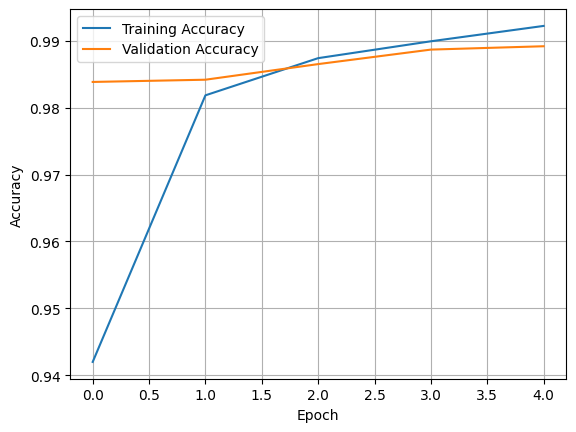

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

# 1. Load MNIST Dataset (60k train, 10k test images)
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# 2. Preprocess Images
#    - Reshape to (28, 28, 1) because CNN expects 4D input
#    - Normalize pixel values to [0,1] for faster training
x_train = x_train.reshape((x_train.shape[0], 28, 28, 1)).astype('float32') / 255
x_test = x_test.reshape((x_test.shape[0], 28, 28, 1)).astype('float32') / 255

# 3. One-Hot Encode Labels
#    Example: '3' → [0 0 0 1 0 0 0 0 0 0]
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# 4. Build CNN Model (Convolutional Neural Network)
model = models.Sequential([

    # First Convolution Layer: 32 filters of size 3x3
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28,28,1)),

    # Downsample image using MaxPooling (reduces 28x28 → 14x14)
    layers.MaxPooling2D((2, 2)),

    # Second Convolution Layer: 64 filters
    layers.Conv2D(64, (3, 3), activation='relu'),

    # Another pooling layer (reduces 12x12 → 6x6)
    layers.MaxPooling2D((2, 2)),

    # Flatten 2D feature maps → 1D vector
    layers.Flatten(),

    # Dense hidden layer with 64 neurons
    layers.Dense(64, activation='relu'),

    # Output layer: 10 neurons (digits 0–9)
    layers.Dense(10, activation='softmax')
])

# 5. Compile Model
#    - Adam optimizer: best default choice
#    - Categorical crossentropy: used for multi-class classification
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 6. Train the Model
#    - epochs=5  → number of times model sees full dataset
#    - batch_size=64 → 64 images per update
#    - validation_split=0.1 → use 10% of training data for validation
history = model.fit(x_train, y_train,
                    epochs=5,
                    batch_size=64,
                    validation_split=0.1)

# 7. Evaluate on Test Set (10,000 unseen images)
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f'Test accuracy: {test_acc:.4f}')

# 8. Plot Accuracy Curve
#    Helps monitor training vs validation performance
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# DL 5

Implement an LSTM-based RNN for text classification to demonstrate sequence modelling, unfloding computational graphs, and handling long-term dependencies.

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

Training...
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


313/313 ━━━━━━━━━━━━━━━━━━━━ 57s 176ms/step - accuracy: 0.5340 - loss: 0.6877 - val_accuracy: 0.7286 - val_loss: 0.5788
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 72s 145ms/step - accuracy: 0.6738 - loss: 0.6010 - val_accuracy: 0.6228 - val_loss: 0.6313
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 47s 149ms/step - accuracy: 0.6810 - loss: 0.5402 - val_accuracy: 0.7994 - val_loss: 0.4683
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 55s 175ms/step - accuracy: 0.7431 - loss: 0.5209 - val_accuracy: 0.5778 - val_loss: 0.6457
Epoch 5/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 49s 156ms/step - accuracy: 0.6600 - loss: 0.5931 - val_accuracy: 0.5826 - val_loss: 0.6556

Evaluating on test set...
782/782 ━━━━━━━━━━━━━━━━━━━━ 24s 30ms/step - accuracy: 0.5806 - loss: 0.6585

 Test Accuracy: 0.5755


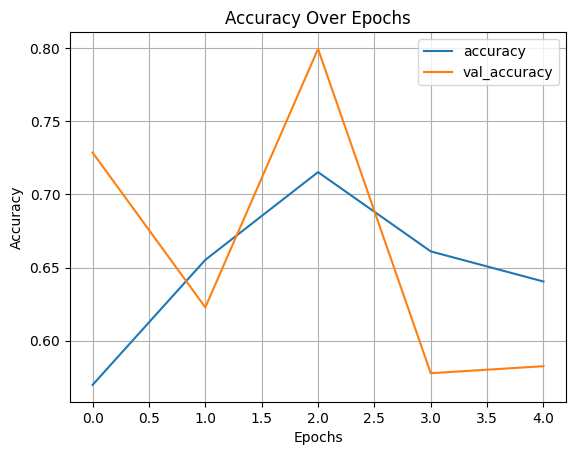

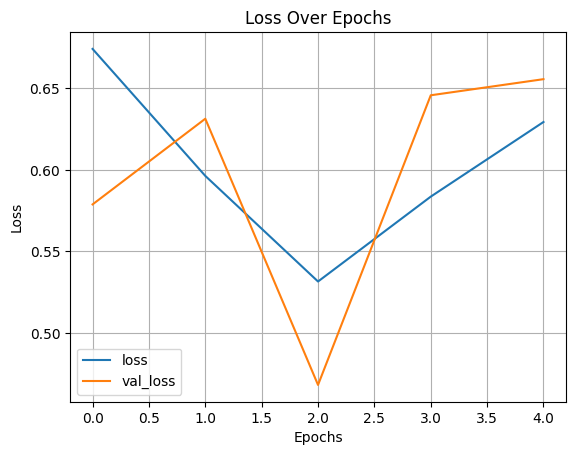

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
import matplotlib.pyplot as plt

# Load IMDB dataset with top 10,000 words
vocab_size = 10000
max_sequence_length = 200
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=vocab_size)

# Pad sequences to the same length (200 tokens)
x_train = pad_sequences(x_train, maxlen=max_sequence_length, padding='post')
x_test = pad_sequences(x_test, maxlen=max_sequence_length, padding='post')

# Build the LSTM sentiment analysis model
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=64, input_length=max_sequence_length))  # Word embeddings
model.add(LSTM(units=64, return_sequences=False))  # LSTM layer
model.add(Dropout(0.5))  # Prevent overfitting
model.add(Dense(1, activation='sigmoid'))  # Binary classification output

# Compile model with Adam and binary crossentropy
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print("\nTraining...")
# Train the model with 20% validation split
history = model.fit(
    x_train,
    y_train,
    epochs=5,
    batch_size=64,
    validation_split=0.2
)

print("\nEvaluating on test set...")
# Evaluate accuracy on unseen test data
loss, accuracy = model.evaluate(x_test, y_test)
print(f"\n Test Accuracy: {accuracy:.4f}")

# Function to plot accuracy or loss curves
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_' + string])
    plt.xlabel("Epochs")
    plt.ylabel(string.capitalize())
    plt.title(f"{string.capitalize()} Over Epochs")
    plt.legend([string, 'val_' + string])
    plt.grid(True)
    plt.show()

# Plot accuracy curve
plot_graphs(history, "accuracy")

# Plot loss curve
plot_graphs(history, "loss")

# Save model to file
model.save("lstm.h5")

# DL 6

Construct BiDirectional RNN and compare its performance with a standard RNN on sequence prediction tasks.


In [ ]:
import torch  # PyTorch main library
import torch.nn as nn  # neural network layers
import torch.optim as optim  # optimizers like Adam
import numpy as np  # numerical operations

seq_length = 10  # each sequence has 10 numbers
num_samples = 1000  # total 1000 training samples
x = []  # input sequences
y = []  # target outputs

for _ in range(num_samples):
  start = np.random.randint(1, 100)  # pick random start number
  seq = np.arange(start, start + seq_length)  # generate increasing sequence
  x.append(seq[:-1])  # first 9 numbers as input
  y.append(seq[-1])  # last number as target

x = torch.tensor(x, dtype=torch.float32).unsqueeze(-1)  # convert to tensor, add feature dimension
y = torch.tensor(y, dtype=torch.float32).unsqueeze(-1)  # target as tensor with feature dimension

class SimpleRNN(nn.Module):  # basic RNN model
  def __init__(self, input_size=1, hidden_size=32, output_size=1):
    super(SimpleRNN, self).__init__()
    self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)  # simple RNN layer
    self.fc = nn.Linear(hidden_size, output_size)  # final linear layer

  def forward(self, x):
    out, _ = self.rnn(x)  # run sequence through RNN
    return self.fc(out)  # apply linear layer to each time step

class BiRNN(nn.Module):  # bidirectional RNN model
  def __init__(self, input_size=1, hidden_size=32, output_size=1):
    super(BiRNN, self).__init__()
    self.rnn = nn.RNN(input_size, hidden_size, batch_first=True, bidirectional=True)  # BiRNN layer
    self.fc = nn.Linear(hidden_size * 2, output_size)  # twice hidden size for bidirectional output

  def forward(self, x):
    out, _ = self.rnn(x)  # forward + backward pass
    return self.fc(out)  # final linear layer

def train_model(model, x, y, epochs=50):
  criterion = nn.MSELoss()  # loss for regression
  optimizer = optim.Adam(model.parameters(), lr=0.01)  # Adam optimizer

  for epoch in range(epochs):
    optimizer.zero_grad()  # clear old gradients
    output = model(x)  # forward pass

    loss = criterion(output[:, -1, :], y)  # use last time step output
    loss.backward()  # compute gradients
    optimizer.step()  # update weights

  return loss.item()  # return final loss

rnn_model = SimpleRNN()  # create simple RNN
birnn_model = BiRNN()  # create bidirectional RNN

rnn_loss = train_model(rnn_model, x, y)  # train simple RNN
birnn_loss = train_model(birnn_model, x, y)  # train BiRNN

print(f"Final Loss (RNN): {rnn_loss:.4f}")  # print RNN loss
print(f"Final Loss (BiRNN): {birnn_loss:.4f}")  # print BiRNN loss

/tmp/ipython-input-1470765316.py:17: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  x = torch.tensor(x, dtype=torch.float32).unsqueeze(-1)  # convert to tensor, add feature dimension


Final Loss (RNN): 2717.9995
Final Loss (BiRNN): 1672.3147


# DL 7

Implement an encoder-decoder architecture with LSTMs for sequence-to-sequence learning.

In [ ]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense

# Sample data: input -> output (reverse sequence)
num_samples = 1000
timesteps = 5
input_dim = 1
latent_dim = 32

# Create toy data
X = np.random.rand(num_samples, timesteps, input_dim)
Y = np.flip(X, axis=1)  # reversed sequences

# Encoder
encoder_inputs = Input(shape=(timesteps, input_dim))
encoder_outputs, state_h, state_c = LSTM(latent_dim, return_state=True)(encoder_inputs)
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = Input(shape=(timesteps, input_dim))
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(input_dim)
decoder_outputs = decoder_dense(decoder_outputs)

# Full model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='adam', loss='mse')

# Train (teacher forcing — decoder gets previous true sequence)
model.fit([X, Y], Y, epochs=10, batch_size=32)

# Test
pred = model.predict([X[:1], Y[:1]])
print("Input:\n", X[0].squeeze())
print("Predicted reversed:\n", pred[0].squeeze())
print("True reversed:\n", Y[0].squeeze())


Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.2567
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0715
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0605
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0551
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0489
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0416
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0326
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0157
Epoch 9/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0033
Epoch 10/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.3383e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
Input:
 [0.37993197 0.68412005 0.93445758 0.72170428 0.46555022]
Predicted reversed:
 [0.4872113 0.7462794 0.9414227 0.6635537 0.3767775]
True reversed:
 [0.46555022 0.72170428 0.93445758 0.68412005 0.37993197]


# DL 8

Implement a Restricted Boltzmann Machine (RBM) for learning binary data representations.


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5, Reconstruction Loss: 0.1194
Epoch 2/5, Reconstruction Loss: 0.0842
Epoch 3/5, Reconstruction Loss: 0.0747
Epoch 4/5, Reconstruction Loss: 0.0694
Epoch 5/5, Reconstruction Loss: 0.0657


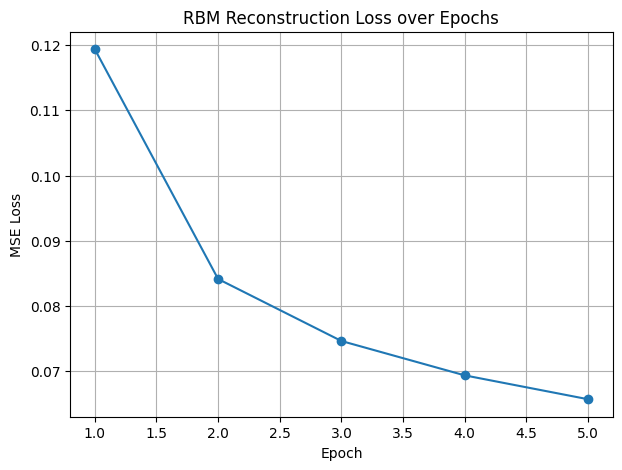

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


(x_train, _), _ = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32') / 255.0
x_train = (x_train > 0.5).astype('float32')
x_train = x_train.reshape(-1, 784)

batch_size = 64
train_dataset=tf.data.Dataset.from_tensor_slices(x_train).shuffle(10000).batch(batch_size)


class RBM(tf.keras.Model):
    def __init__(self, n_visible, n_hidden):
        super(RBM, self).__init__()
        self.n_visible = n_visible
        self.n_hidden = n_hidden
        initializer = tf.initializers.RandomNormal(mean=0.0, stddev=0.01)
        self.W = tf.Variable(initializer([n_visible, n_hidden]), name='weights')
        self.h_bias = tf.Variable(tf.zeros([n_hidden]), name='hidden_bias')
        self.v_bias = tf.Variable(tf.zeros([n_visible]), name='visible_bias')

    def sample_prob(self, probs):
        """Sample binary values from probabilities."""
        return tf.nn.relu(tf.sign(probs - tf.random.uniform(tf.shape(probs))))

    def sample_h(self, v):
        prob_h = tf.nn.sigmoid(tf.matmul(v, self.W) + self.h_bias)
        return prob_h, self.sample_prob(prob_h)

    def sample_v(self, h):
        prob_v = tf.nn.sigmoid(tf.matmul(h, tf.transpose(self.W)) + self.v_bias)
        return prob_v, self.sample_prob(prob_v)

    def contrastive_divergence(self, v, lr=0.01):
        # Positive phase
        prob_h, h0 = self.sample_h(v)

        # Negative phase (reconstruction)
        prob_v, v1 = self.sample_v(h0)
        prob_h1, _ = self.sample_h(v1)

        # Compute gradients
        positive_grad = tf.matmul(tf.transpose(v), prob_h)
        negative_grad = tf.matmul(tf.transpose(v1), prob_h1)

        # Update weights and biases
        batch_size = tf.cast(tf.shape(v)[0], tf.float32)
        self.W.assign_add(lr * (positive_grad - negative_grad) / batch_size)
        self.v_bias.assign_add(lr * tf.reduce_mean(v - v1, axis=0))
        self.h_bias.assign_add(lr * tf.reduce_mean(prob_h - prob_h1, axis=0))

        # Compute reconstruction loss (MSE)
        loss = tf.reduce_mean(tf.square(v - v1))
        return loss

# --- Initialize and train RBM ---
n_visible=784
n_hidden=128
rbm = RBM(n_visible, n_hidden)

n_epochs = 5
lr = 0.05
losses = []

for epoch in range(n_epochs):
    epoch_loss = 0
    for batch in train_dataset:
        loss = rbm.contrastive_divergence(batch, lr)
        epoch_loss += loss.numpy()
    avg_loss = epoch_loss / len(list(train_dataset))
    losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{n_epochs}, Reconstruction Loss: {avg_loss:.4f}")

# --- Plot training loss ---
plt.figure(figsize=(7, 5))
plt.plot(range(1, n_epochs+1), losses, marker='o')
plt.title("RBM Reconstruction Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid(True)
plt.show()


# DL 9

Develop a Denoising Autoencoder to reconstruct clean images from noisy input data.

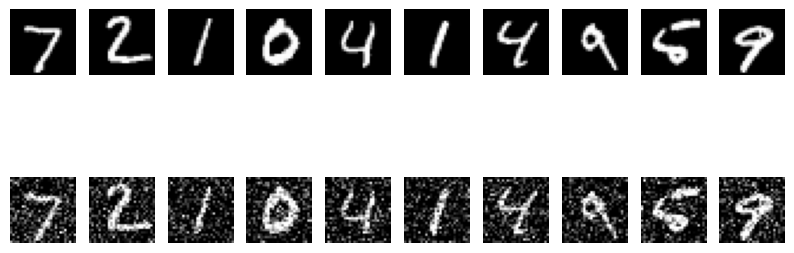

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 190s 799ms/step - loss: 0.2589 - val_loss: 0.0975
Epoch 2/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 192s 758ms/step - loss: 0.0943 - val_loss: 0.0882
Epoch 3/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 181s 769ms/step - loss: 0.0885 - val_loss: 0.0854
Epoch 4/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 195s 740ms/step - loss: 0.0857 - val_loss: 0.0835
Epoch 5/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 174s 740ms/step - loss: 0.0841 - val_loss: 0.0822
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step


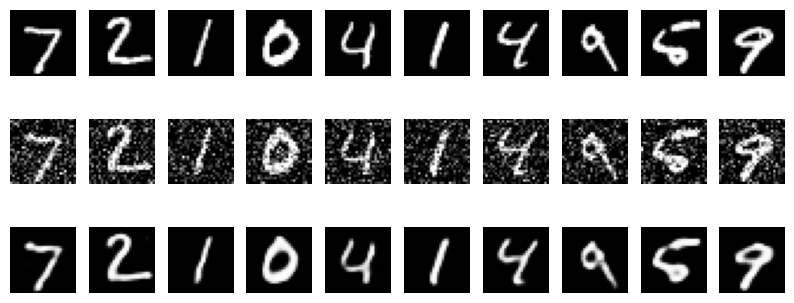

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt

# Load and normalize MNIST dataset
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train, x_test = np.expand_dims(x_train, -1), np.expand_dims(x_test, -1)

# Add random noise
x_train_noisy = np.clip(x_train + 0.3 * np.random.normal(0, 1, x_train.shape), 0, 1)
x_test_noisy = np.clip(x_test + 0.3 * np.random.normal(0, 1, x_test.shape), 0, 1)

# Visualize clean vs noisy images
plt.figure(figsize=(10, 4))
for i in range(10):
    plt.subplot(2, 10, i+1);
    plt.imshow(x_test[i].squeeze(), cmap='gray'); plt.axis('off')
    plt.subplot(2, 10, i+11);
    plt.imshow(x_test_noisy[i].squeeze(), cmap='gray'); plt.axis('off')
plt.show()

# Build autoencoder
autoencoder = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(28,28,1)),
    layers.MaxPooling2D((2,2), padding='same'),
    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2), padding='same'),
    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.UpSampling2D((2,2)),
    layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    layers.UpSampling2D((2,2)),
    layers.Conv2D(1, (3,3), activation='sigmoid', padding='same')
])

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(x_train_noisy, x_train, epochs=5, batch_size=256,
                validation_data=(x_test_noisy, x_test))

# Predict and visualize denoised images
decoded = autoencoder.predict(x_test_noisy)

plt.figure(figsize=(10, 4))
for i in range(10):
    plt.subplot(3, 10, i+1);
    plt.imshow(x_test[i].squeeze(), cmap='gray');
    plt.axis('off')
    plt.subplot(3, 10, i+11);
    plt.imshow(x_test_noisy[i].squeeze(), cmap='gray');
    plt.axis('off')
    plt.subplot(3, 10, i+21);
    plt.imshow(decoded[i].squeeze(), cmap='gray');
    plt.axis('off')
plt.show()


# DL 10

Implement a simple Generative Adversarial Network (GAN) on the MNIST dataset to generate new handwritten digits.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/trainer.py:83: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


Step 0 | D loss: 0.718 | G loss: 0.695


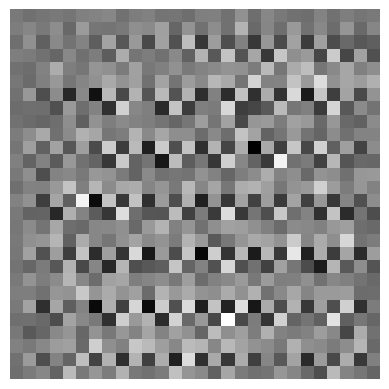

Step 500 | D loss: 1.159 | G loss: 0.250


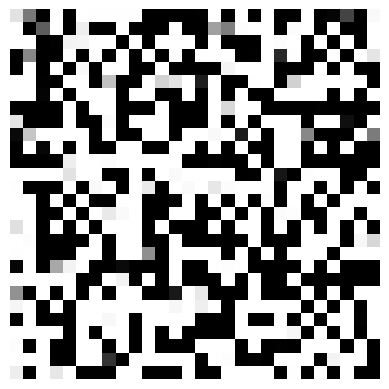

Step 1000 | D loss: 1.207 | G loss: 0.219


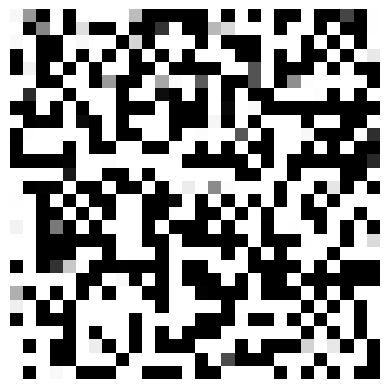

Step 1500 | D loss: 1.226 | G loss: 0.208


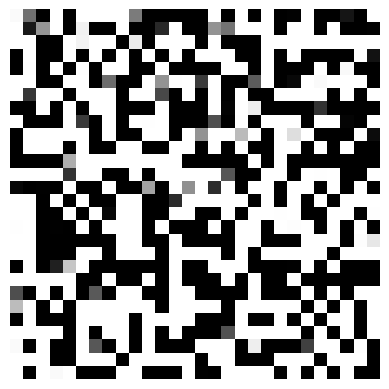

Step 2000 | D loss: 1.237 | G loss: 0.202


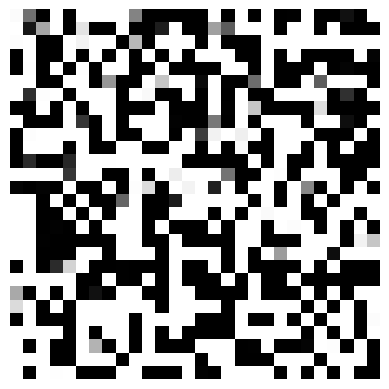

Step 2500 | D loss: 1.247 | G loss: 0.196


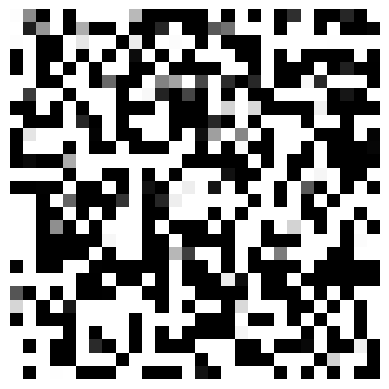

Step 3000 | D loss: 1.255 | G loss: 0.192


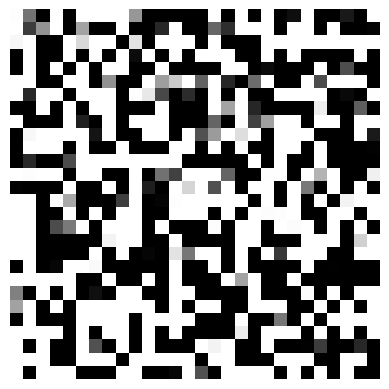

Step 3500 | D loss: 1.262 | G loss: 0.189


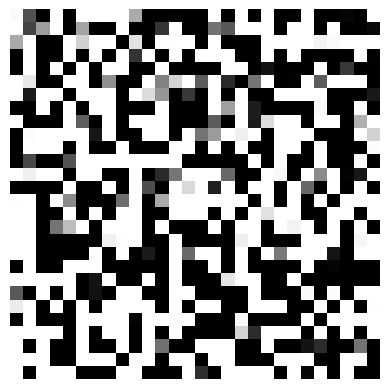

Step 4000 | D loss: 1.267 | G loss: 0.187


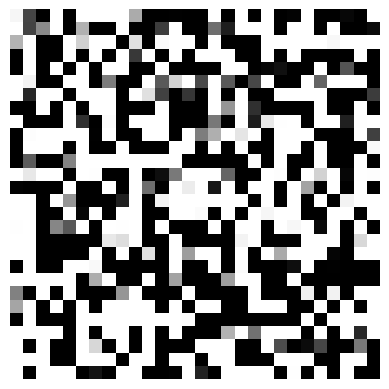

Step 4500 | D loss: 1.271 | G loss: 0.185


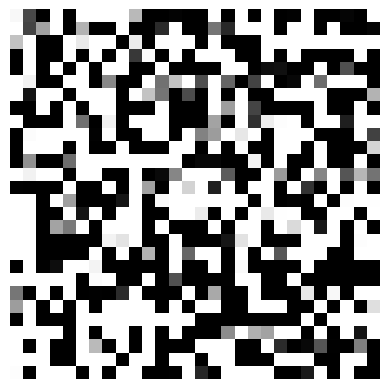

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

# Load and normalize MNIST
(x_train, _), _ = tf.keras.datasets.mnist.load_data()
x_train = (x_train.astype("float32") - 127.5) / 127.5
x_train = np.expand_dims(x_train, axis=-1)
batch_size = 128
buffer_size = 60000
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(buffer_size).batch(batch_size)

# Generator
def build_generator():
    model = tf.keras.Sequential([
        layers.Dense(7*7*128, input_dim=100),
        layers.LeakyReLU(0.2),
        layers.Reshape((7,7,128)),
        layers.Conv2DTranspose(64, (5,5), strides=2, padding="same"),
        layers.LeakyReLU(0.2),
        layers.Conv2DTranspose(1, (5,5), strides=2, padding="same", activation="tanh")
    ])
    return model

# Discriminator
def build_discriminator():
    model = tf.keras.Sequential([
        layers.Conv2D(64, (5,5), strides=2, padding="same", input_shape=[28,28,1]),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.3),
        layers.Conv2D(128, (5,5), strides=2, padding="same"),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.3),
        layers.Flatten(),
        layers.Dense(1, activation="sigmoid")
    ])
    return model

# Models
generator = build_generator()
discriminator = build_discriminator()
discriminator.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# GAN combined model
discriminator.trainable = False
gan_input = tf.keras.Input(shape=(100,))
gan_output = discriminator(generator(gan_input))
gan = tf.keras.Model(gan_input, gan_output)
gan.compile(loss="binary_crossentropy", optimizer="adam")

# --- Training ---
epochs = 5000  # Small but enough to get clear digits
for step in range(epochs):
    # Train Discriminator
    noise = np.random.normal(0, 1, (batch_size, 100))
    fake = generator.predict(noise, verbose=0)
    real = x_train[np.random.randint(0, x_train.shape[0], batch_size)]
    X = np.concatenate([real, fake])
    y = np.concatenate([np.ones((batch_size,1)), np.zeros((batch_size,1))])
    d_loss, _ = discriminator.train_on_batch(X, y)

    # Train Generator
    noise = np.random.normal(0, 1, (batch_size, 100))
    y_gen = np.ones((batch_size,1))
    g_loss = gan.train_on_batch(noise, y_gen)

    # Print progress and save sample every 500 steps
    if step % 500 == 0:
        print(f"Step {step} | D loss: {d_loss:.3f} | G loss: {g_loss:.3f}")
        z = np.random.normal(0,1,(1,100))
        gen_img = generator.predict(z, verbose=0)[0,:,:,0]
        plt.imshow(gen_img * 0.5 + 0.5, cmap="gray")
        plt.axis("off")
        plt.show()
